In [1]:
with open("requirements.txt", "r") as config_file:
    config_code = config_file.read()
    exec(config_code)
%load_ext autoreload
%autoreload 2

### Data

In [77]:
tidy_finance = sqlite3.connect(database="data/specialedata.sqlite")

macro_predictors = (pd.read_sql_query(
    sql="SELECT * FROM macro_predictors",
    con=tidy_finance,
    parse_dates={"month"})
 .add_prefix("macro_")
)

JKPFactors = (pd.read_sql_query(
  sql="SELECT * FROM JKPFactors",
  con=tidy_finance,
  parse_dates={"month"})
  .add_prefix("jkp_factor_")
)
JKPFactornames = JKPFactors.columns

factors_ff3_monthly = (pd.read_sql_query(
     sql="SELECT * FROM factors_ff3_monthly",
     con=tidy_finance,
     parse_dates={"month"})
  .add_prefix("factor_ff3_")
)

factors_ff5_monthly = (pd.read_sql_query(
     sql="SELECT * FROM factors_ff5_monthly",
     con=tidy_finance,
     parse_dates={"month"})
  .add_prefix("factor_ff5_")
)

ff_carhart = (pd.read_sql_query(
    sql="SELECT * FROM ff_carhart",
    con=tidy_finance,
    parse_dates={"month"})
 .add_prefix("ff_carhart_")
)

crsp_2000 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_2000",
    con=tidy_finance,
    parse_dates={"month"})
)

crsp_1500 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_1500",
    con=tidy_finance,
    parse_dates={"month"})
)

crsp_1000 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_1000",
    con=tidy_finance,
    parse_dates={"month"})
)
crsp_500 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_500",
    con=tidy_finance,
    parse_dates={"month"})
)
crsp_250 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_250",
    con=tidy_finance,
    parse_dates={"month"})
)

crsp_100 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_100",
    con=tidy_finance,
    parse_dates={"month"})
)

crsp_50 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_50",
    con=tidy_finance,
    parse_dates={"month"})
)

# Select amount of tickers in cross section!
data_total = (crsp_100
        .merge(JKPFactors,
               how = "left", left_on = "month", right_on = "jkp_factor_month")
        .merge(macro_predictors,
             how = "left", left_on = "month", right_on = "macro_month")
        .merge(factors_ff5_monthly,
               how = "left", left_on = "month", right_on = "factor_ff5_month")
         .merge(ff_carhart,
               how = "left", left_on = "month", right_on = "ff_carhart_month")
        .assign(ret_excess=lambda x: x["ret"] - x["factor_ff5_rf"]) 
        .drop(columns=['ret', 'jkp_factor_month', 'macro_month', 'factor_ff5_month', 'ff_carhart_month','ff_carhart_rf','ff_carhart_mkt_excess','ff_carhart_smb','ff_carhart_hml'])
        .dropna()
       )

# Make a dataframe for stock characteristics and factors
macro_variables = data_total.filter(like="macro").columns
factor_variables = data_total.filter(like="jkp_factor").columns
macro_factors = data_total[macro_variables]
factors = data_total[macro_variables].merge(data_total[factor_variables], left_index=True, right_index=True)
char = data_total[['mktcap', 'mktcap_lag_1', 'mktcap_lag_3', 'mktcap_lag_6', 'mktcap_lag_12', 'mom_1', 'mom_3','mom_6', 'mom_12']]
# List of tickers
tickers = data_total['ticker'].unique()

# Transform data
column_combinations = list(product(macro_factors, char)) 

new_column_values = []
for macro_column, char in column_combinations:
    new_column_values.append(data_total[macro_column] * data_total[char])

column_names = [" x ".join(t) for t in column_combinations]
new_columns = pd.DataFrame(dict(zip(column_names, new_column_values)))

# New data set with added combinations
data = pd.concat([data_total, new_columns], axis=1)

preprocessor = ColumnTransformer(
  transformers=[
    ("scale", StandardScaler(), 
    [col for col in data.columns 
      if col not in ["ret_excess", "month", "ticker"]])
  ],
  remainder="drop",
  verbose_feature_names_out=False
)
training_date = "2017-07-01"

In [60]:
data = data_total.set_index(["ticker","month"])
cols = list(data.columns)
cols.insert(0, cols.pop(cols.index('ret_excess')))
data = data[cols]
data = data.iloc[:,:167] # Ensure full rank

In [56]:
def train_test_split(data):
    training_date = "2017-07-01"
    # Step 1: Filter data until the training date
    data_train = data[data.index.get_level_values('month') <= training_date]
    data_test = data[data.index.get_level_values('month') > training_date]

    # Step 2: Prepare exogenous and endogenous variables
    exog_vars = data.columns[1:].tolist()
    endog_vars = ['ret_excess']  # Corrected spelling
    X_train = sm.add_constant(data_train[exog_vars])
    y_train = data_train[endog_vars]
    
    X_test = data_test[exog_vars]
    y_test = data_test[endog_vars]
    
    return X_train, y_train, X_test, y_test
    
def R_oos(y_test, y_pred):
    y_test, y_pred = np.array(y_test).flatten(), np.array(y_pred).flatten()
    return 1 - (np.dot((y_test-y_pred),(y_test-y_pred)))/(np.dot(y_test,y_test))

def estimate(data, X_train, y_train, X_test, y_test):
    model = PooledOLS(y_train, X_train)
    pooled_res = model.fit()
    
    data_forecast = data[data.index.get_level_values('month') > training_date]
    exog_vars = data.columns[1:].tolist()
    X_forecast = sm.add_constant(data_forecast[exog_vars])
    y_fitted = pooled_res.fitted_values

    y_pred = pooled_res.predict(X_forecast)
    print(f'Out-of-sample R-squared: {round(R_oos(y_test,y_pred),4)}')
    return y_pred, y_fitted

def plot(data, y_pred, y_fitted, dataset_name):
    training_date = "2017-07-01"
    plt.figure(figsize=(8, 3))

    # Sort the DataFrame by index
    df_sorted = data.sort_index()
    y_pred = y_pred.sort_index()
    y_fitted = y_fitted.sort_index()
    # Plot line plots first
    for ticker in df_sorted.index.levels[0]:
        data_ticker = df_sorted.loc[ticker]
        plt.scatter(data_ticker.index.get_level_values('month'), data_ticker['ret_excess'], label=ticker, color='deepskyblue', s=5, zorder=10, marker='o')
        plt.scatter(y_pred.loc[ticker].index.get_level_values('month'), y_pred.loc[ticker]['predictions'], label=ticker, color='red', s=5, zorder=10, marker='o')
        plt.scatter(y_fitted.loc[ticker].index.get_level_values('month'), y_fitted.loc[ticker]['fitted_values'], label=ticker, color='red', s=5, zorder=10, marker='o')
    
    plt.axvspan(training_date, max(data.index.get_level_values('month')), color='gray', alpha=0.2)
    plt.grid(color='lightgray', linewidth=0.5, alpha=0.5)
    plt.title(f'{dataset_name.upper()}', size = 8)

    plt.xlabel('Month')
    plt.ylabel('Excess Return')

    # Save
    save_dir = 'plots/predictions'
    os.makedirs(save_dir, exist_ok=True)
    # Number of tickers in dataset
    tickers = len(data.index.get_level_values('ticker').unique())
    # Save the plot
    save_path = os.path.join(save_dir, f'{tickers}_plot_{dataset_name.lower()}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [61]:
X_train, y_train, X_test, y_test = train_test_split(data)

In [62]:
y_pred, y_fitted = estimate(data, X_train, y_train, X_test, y_test)

Out-of-sample R-squared: 0.0028


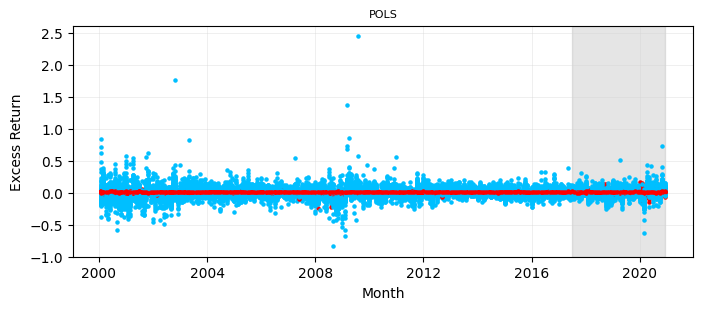

In [63]:
plot(data, y_pred, y_fitted, dataset_name = 'POLS')

### Regularization

In [78]:
data = data_total.set_index(["ticker","month"])
cols = list(data.columns)
cols.insert(0, cols.pop(cols.index('ret_excess')))
data = data[cols]
def train_test_split_regularization(data):
    y = data['ret_excess']
    X = data.drop(columns = ['ret_excess'])
    scaler = StandardScaler()
    X_scaled_array = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled_array, index = X.index, columns = X.columns)
    # Training 80 pct.
    training_date = "2017-07-01"
    X_train = X_scaled[X.index.get_level_values('month') < training_date]
    X_test = X_scaled[X.index.get_level_values('month') >= training_date]
    y_train = y[y.index.get_level_values('month') < training_date]
    y_test = y[y.index.get_level_values('month') >= training_date]
    
    n_features = X_train.shape[1] # Number of features
    feature_names = data.drop(columns=['ret_excess']).columns.tolist() # Feature names
    
    n_features = X_train.shape[1] # Number of features
    feature_names = data.drop(columns=['ret_excess']).columns.tolist() # Feature names
    y_train_ = np.array(y_train).reshape(-1,1)
    return X_train, X_test, y_train, y_test, y_train_, n_features, feature_names

def optimal_alpha_EN(X_train,y_train_, l1_ratio):
    alphas = np.logspace(-6, -4, 100)
    
    lm_model = ElasticNet(alpha=0.006,
                          l1_ratio=l1_ratio,
                          max_iter=1000,
                          fit_intercept=False)
    # Set up GridSearchCV
    grid_search = GridSearchCV(estimator=lm_model, param_grid={'alpha': alphas}, scoring='neg_mean_squared_error', cv=5)
    
    # Fit the grid search to the training data
    grid_search.fit(X_train.values, y_train_)
    best_alpha = grid_search.best_params_['alpha']
    best_alpha_str = "{:.10f}".format(round(best_alpha, 10))
    
    # Print the rounded alpha value
    if l1_ratio == 1: 
        print(f'Optimal Alpha (Lasso): {best_alpha_str}')
    else:
         print(f'Optimal Alpha (EN): {best_alpha_str}')
    return best_alpha

def optimal_alpha_Ridge(X_train,y_train_):
    alphas = np.logspace(-6, 6, 100)
    
    lm_model = Ridge(alpha=0.006,
                          max_iter=1000,
                          fit_intercept=False)
    # Set up GridSearchCV
    grid_search = GridSearchCV(estimator=lm_model, param_grid={'alpha': alphas}, scoring='neg_mean_squared_error', cv=5)
    
    # Fit the grid search to the training data
    grid_search.fit(X_train.values, y_train_)
    best_alpha = grid_search.best_params_['alpha']
    best_alpha_str = "{:.10f}".format(round(best_alpha, 10))
    
    # Print the rounded alpha value
    print(f'Optimal Alpha (Ridge): {best_alpha_str}')
    return best_alpha

def EN_predict(X_train, y_train_, X_test, y_test, l1_ratio, alpha_opt):
    lm_model = ElasticNet(alpha=alpha_opt,
                          l1_ratio=l1_ratio,
                          max_iter=1000,
                          fit_intercept=False)
    
    lm_fit = lm_model.fit(X_train.values, y_train_)
    predictions = lm_fit.predict(X_test.values)
    fitted = lm_fit.predict(X_train.values)
    
    y_pred = pd.DataFrame(predictions, index = y_test.index)
    y_fitted = pd.DataFrame(fitted, index = y_train.index)
    
    y_pred.columns = ['predictions']
    y_fitted.columns = ['fitted_values']
    print(f'Out-of-sample R-squared =', round(R_oos(y_test, y_pred),4))

    # Creating a binary matrix to store selected features
    selected_features = pd.DataFrame(np.zeros((len(X_train.columns), 1)), index=X_train.columns, columns=['selected'])
    selected_features.loc[lm_fit.coef_ != 0, 'selected'] = 1

    return y_pred, y_fitted, selected_features


def Ridge_predict(X_train, y_train_, X_test, y_test, alpha_opt):
    lm_model = Ridge(alpha=alpha_opt,
                          max_iter=1000,
                          fit_intercept=False)
    
    lm_fit = lm_model.fit(X_train.values, y_train_)
    predictions = lm_fit.predict(X_test.values)
    fitted = lm_fit.predict(X_train.values)
    
    y_pred = pd.DataFrame(predictions, index = y_test.index)
    y_fitted = pd.DataFrame(fitted, index = y_train.index)
    
    y_pred.columns = ['predictions']
    y_fitted.columns = ['fitted_values']
    print(f'Out-of-sample R-squared =', round(R_oos(y_test, y_pred),4))

    # features DataFrame initialization
    features = pd.DataFrame(np.zeros((len(X_train.columns), 1)), index=X_train.columns, columns=['selected'])
    
    # Create coef_df
    coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lm_fit.coef_.flatten()})
    
    # Filter selected features based on coefficient values
    selected_features = coef_df.loc[np.abs(coef_df['Coefficient']) >= 0.002, 'Feature'].tolist()
    
    # Update 'selected' column in features DataFrame
    features.loc[selected_features, 'selected'] = 1
    selected_values = features.loc[features['selected'] > 0.002, 'selected']
    return y_pred, y_fitted,features
    
def plot(data, y_pred, y_fitted, regularizor):
    training_date = "2017-07-01"
    plt.figure(figsize=(8, 3))

    # Sort the DataFrame by index
    df_sorted = data.sort_index()
    y_pred = y_pred.sort_index()
    y_fitted = y_fitted.sort_index()
    # Plot line plots first
    plt.ylim(-1, 3)
    for ticker in df_sorted.index.levels[0]:
        data_ticker = df_sorted.loc[ticker]
        plt.scatter(data_ticker.index.get_level_values('month'), data_ticker['ret_excess'], label=ticker, color='deepskyblue', s=5, zorder=10, marker='o')
        plt.scatter(y_pred.loc[ticker].index.get_level_values('month'), y_pred.loc[ticker]['predictions'], label=ticker, color='red', s=5, zorder=10, marker='o')
        plt.scatter(y_fitted.loc[ticker].index.get_level_values('month'), y_fitted.loc[ticker]['fitted_values'], label=ticker, color='red', s=5, zorder=10, marker='o')
    
    plt.axvspan(training_date, max(data.index.get_level_values('month')), color='gray', alpha=0.2)
    plt.grid(color='lightgray', linewidth=0.5, alpha=0.5)
    plt.title(f'{regularizor.upper()}', size = 8)
    plt.xlabel('Month')
    plt.ylabel('Excess Return')

    # Save
    save_dir = 'plots/predictions'
    os.makedirs(save_dir, exist_ok=True)

    # Number of tickers in dataset
    tickers = len(data.index.get_level_values('ticker').unique())
    # Save the plot
    save_path = os.path.join(save_dir, f'{tickers}_plot_{regularizor}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [79]:
X_train, X_test, y_train, y_test, y_train_, n_features, feature_names = train_test_split_regularization(data)

### Lasso

In [28]:
#alpha_opt_lasso = optimal_alpha_EN(X_train,y_train_,1)
y_pred_lasso, y_fitted_lasso, selected_features_lasso = EN_predict(X_train, y_train_, X_test,y_test, 1, alpha_opt_lasso)

Out-of-sample R-squared = 0.0697


### Ridge

In [31]:
#alpha_opt_ridge = optimal_alpha_Ridge(X_train,y_train_)
y_pred_ridge, y_fitted_ridge, selected_features_ridge = Ridge_predict(X_train, y_train_, X_test,y_test, alpha_opt_ridge)


Out-of-sample R-squared = 0.0306


### Elastic Net

In [33]:
#alpha_opt_en = optimal_alpha_EN(X_train,y_train_,0.5)
y_pred_en, y_fitted_en, selected_features_en = EN_predict(X_train, y_train_, X_test,y_test, 0.5, alpha_opt_en)


Out-of-sample R-squared = 0.0702


### Plots

In [81]:
y_pred_lasso, y_fitted_lasso, selected_features_lasso = EN_predict(X_train, y_train_, X_test,y_test, 1, 0.0000532452)
y_pred_ridge, y_fitted_ridge, selected_features_ridge = Ridge_predict(X_train, y_train_, X_test,y_test, 101.5646332755)
y_pred_en, y_fitted_en, selected_features_en = EN_predict(X_train, y_train_, X_test,y_test, 0.5, 0.000345324)

Out-of-sample R-squared = 0.1375
Out-of-sample R-squared = 0.0778
Out-of-sample R-squared = 0.269


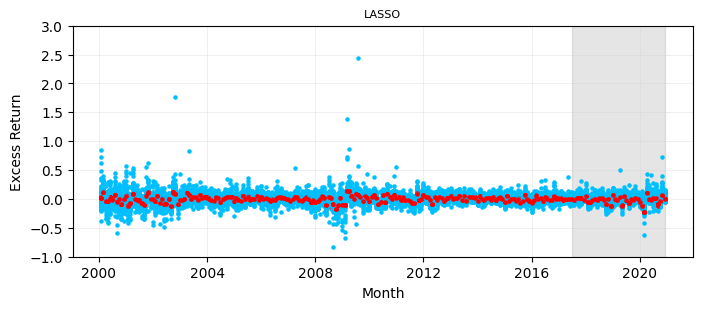

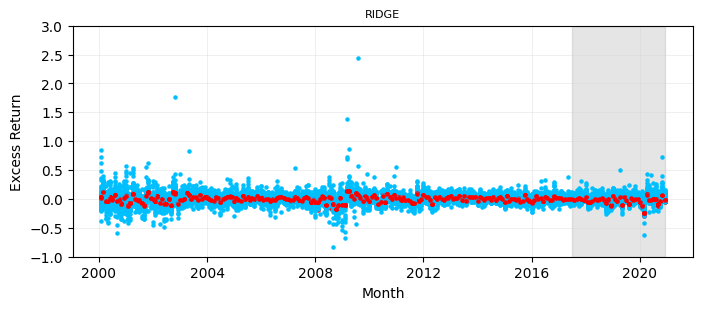

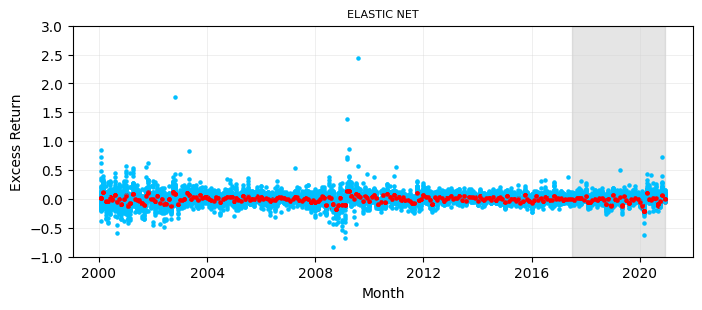

In [76]:
plot(data, y_pred_lasso, y_fitted_lasso, regularizor = 'Lasso')
plot(data, y_pred_ridge, y_fitted_ridge, regularizor = 'Ridge')
plot(data, y_pred_en, y_fitted_en, regularizor = 'Elastic Net')

### Feature selection plot

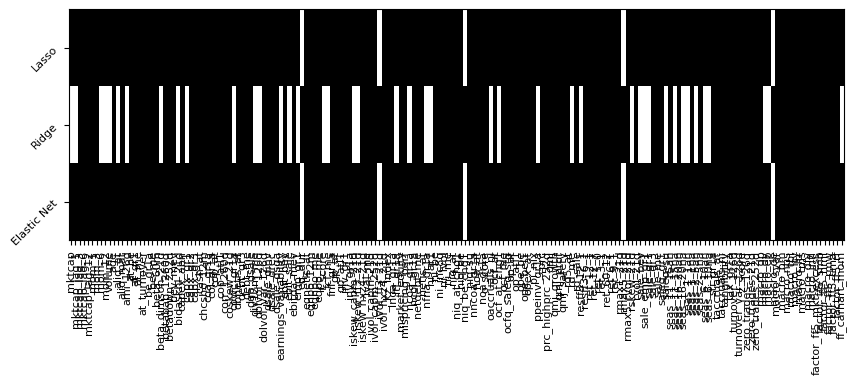

In [21]:
selected_features_combined = pd.concat([selected_features_lasso, selected_features_ridge,selected_features_en], axis=1)
selected_features_combined = selected_features_combined[(selected_features_combined != 0).any(axis=1)]
selected_features_combined.columns = ['Lasso','Ridge','Elastic Net']
cleaned_index = [label.replace("jkp_factor_", "") for label in selected_features_combined.index]
selected_features_combined.index = cleaned_index
plt.figure(figsize=(10, 3))  # Change figsize to adjust for the transposed plot
plt.imshow(selected_features_combined.T, cmap='binary', aspect='auto')  # Transpose selected_features_combined
# Customize plot
plt.yticks(ticks=range(len(selected_features_combined.columns)), labels=selected_features_combined.columns, rotation=45, fontsize=8)  # Change yticks to xticks
plt.xticks(ticks=range(len(selected_features_combined.index)), labels=selected_features_combined.index, rotation=90, fontsize=8)  # Change xticks to yticks

# Show plot
plt.show()

### Lasso

In [11]:
alphas = np.logspace(-1, 6, 100) 
# LASSO
Lasso = ElasticNet(fit_intercept=False, l1_ratio=1, max_iter=5000)

# Set up pipeline
lm_pipeline_Lasso = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", Lasso)
])
params = {"regressor__alpha": alphas}

finder_Lasso = GridSearchCV(
  lm_pipeline_Lasso,
  param_grid=params,
  scoring="neg_root_mean_squared_error",
  cv=5
)
# Fit the model to the entire panel data
start = time.time()
finder_Lasso.fit(
    data.drop(columns=["ret_excess"]), data["ret_excess"]
)
end = time.time()
print(f'{round(end - start,3)/60} minutes')
result_panel_Lasso = pd.DataFrame(finder_Lasso.best_estimator_.named_steps.regressor.coef_ != 0)
optimal_alpha_panel = finder_Lasso.best_params_['regressor__alpha']  # Extract optimal alpha
print("Lasso:", optimal_alpha_panel)

29.16143333333333 minutes
Lasso: 0.1


In [12]:
# Store optimal lasso alphas 
lasso_alpha_1000 = 0.001402
lasso_alpha_500 = 0.00121
lasso_alpha_250 = 0.001542123
lasso_alpha_100 = 0.001
lasso_alpha_50 = 0.0012045035402587824


Out-of-sample R^2: -0.0381
MSPE: 0.0148


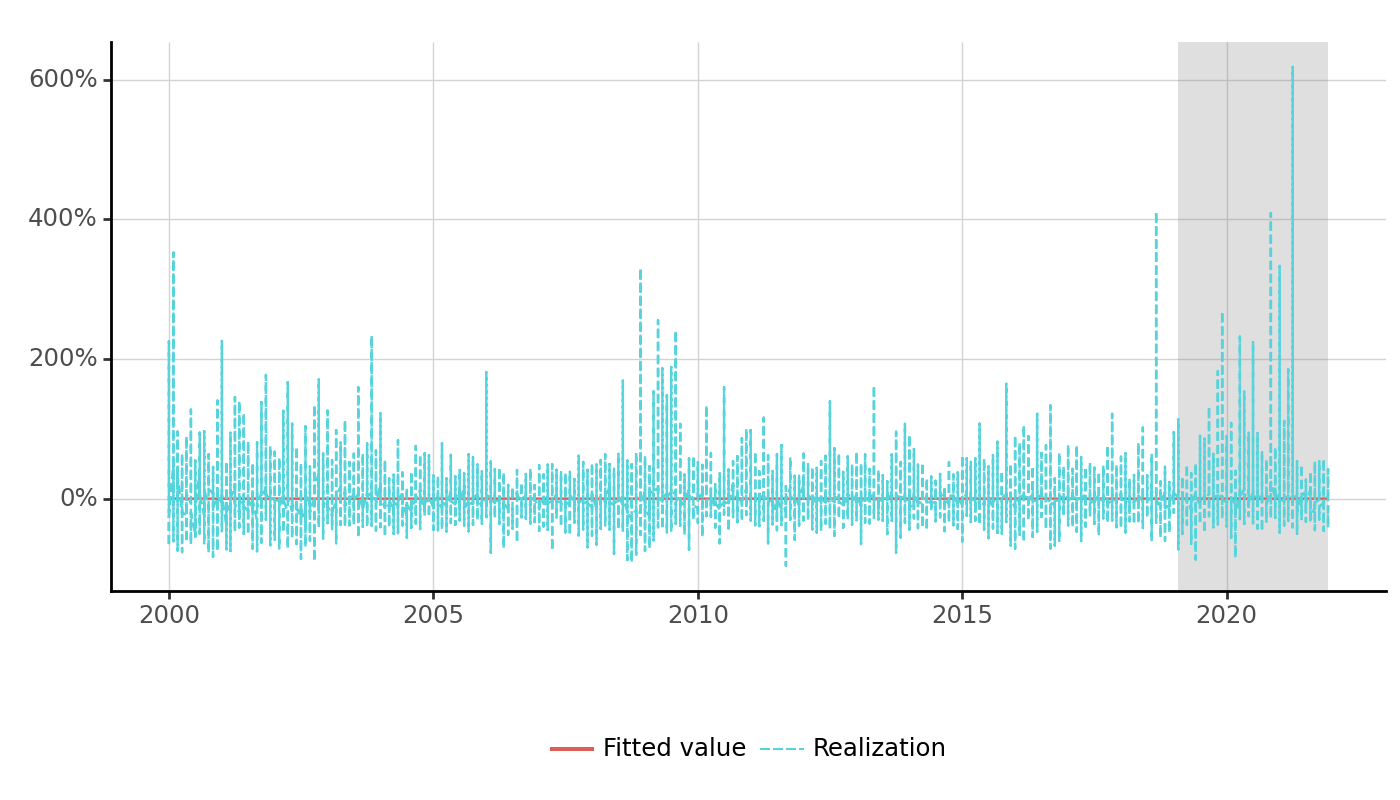

In [13]:
# Set up Lasso Net Model
lm_model = ElasticNet(
    alpha=optimal_alpha_panel, # Strength of regularization (lambda penalty)
    l1_ratio=1, # Weight on Lasso vs Ridge (l1_ratio = 1, means 100 pct. Lasso)
    max_iter=5000, # Maximum number of iteration for optimization
    fit_intercept=False 
)  
    
lm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", lm_model)
])
print(pl.prediction_plot_panel(data, lm_pipeline))

### Ridge

In [14]:
alphas_ridge = np.logspace(-1, 6, 100) 
# RIDGE
ridge = Ridge(fit_intercept=False)

# Set up pipeline
lm_pipeline_Ridge = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", ridge)
])

# Set up grid search
params = {"regressor__alpha": alphas_ridge}

finder_Ridge = GridSearchCV(
  lm_pipeline_Ridge,
  param_grid=params,
  scoring="neg_mean_squared_error",
  cv=5
)
start = time.time()


# Fit the model to the entire panel data
finder_Ridge.fit(
    data.drop(columns=["ret_excess"], axis = 1), data["ret_excess"]
)
end = time.time()
print(f'{round(end - start,3)/60} minutes')

# Store results
result_panel_Ridge = pd.DataFrame(finder_Ridge.best_estimator_.named_steps.regressor.coef_ != 0)

optimal_alpha_panel_Ridge = finder_Ridge.best_params_['regressor__alpha']  # Extract optimal alpha
print("Ridge:", optimal_alpha_panel_Ridge)

27.827566666666666 minutes
Ridge: 4641.588833612773


In [15]:
# Store optimal ridge alphas 
#RidgeALPHA_1000 = 
RidgeALPHA_500 = 0.174729
RidgeALPHA_250 = 0.15034
RidgeALPHA_100 = 0.010045034503
RidgeALPHA_50 = 0.104503


Out-of-sample R^2: 0.1589
MSPE: 0.012


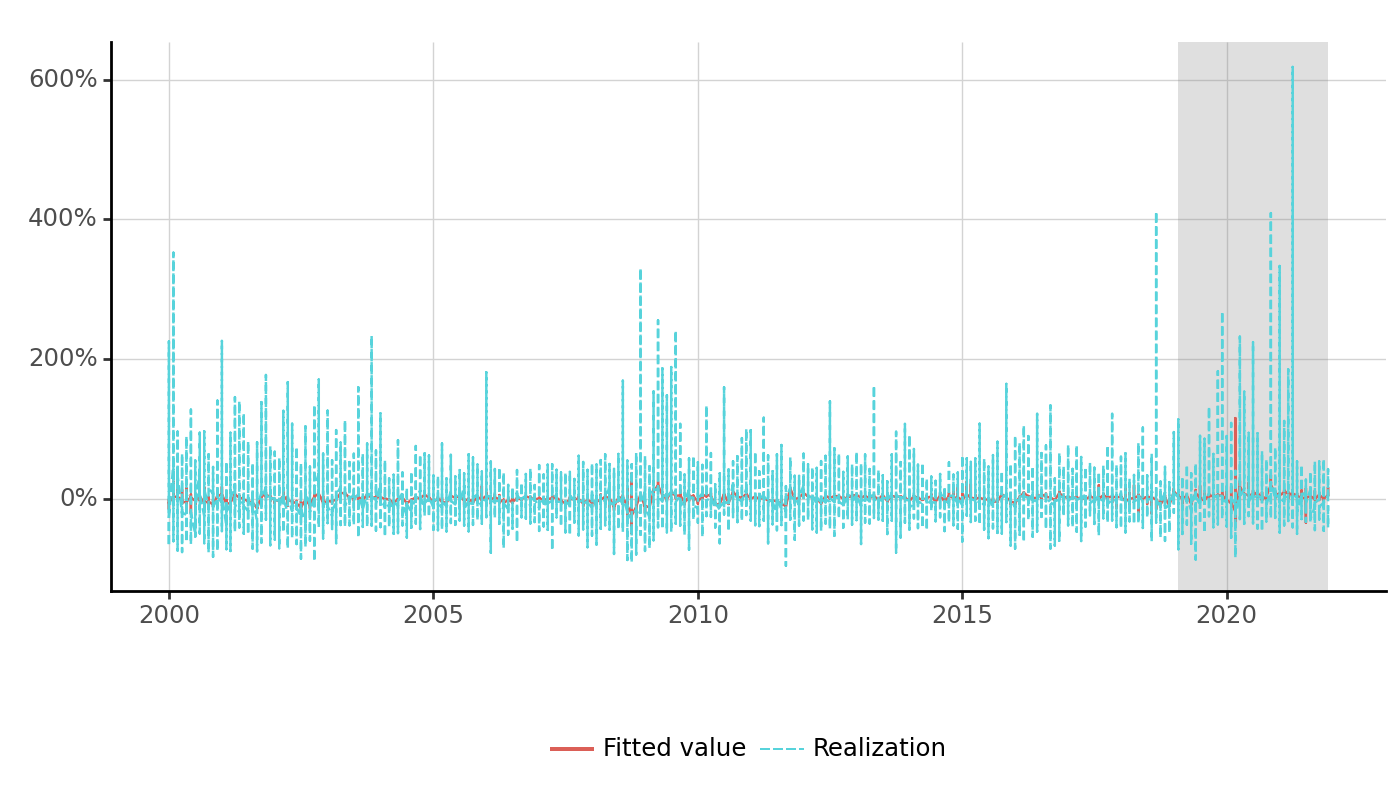

In [16]:
# Set up Ridge Model
lm_model = Ridge(
    alpha=optimal_alpha_panel_Ridge, # Strength of regularization (lambda penalty)
    fit_intercept=False 
)  
    
lm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", lm_model)
])
print(pl.prediction_plot_panel(data, lm_pipeline))

### Elastic Net

In [ ]:
# Elastic Net
EN = ElasticNet(fit_intercept=False, l1_ratio=0.5, max_iter=5000)

# Set up pipeline
lm_pipeline_EN = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", Lasso)
])
params = {"regressor__alpha": alphas}

finder_EN = GridSearchCV(
  lm_pipeline_EN,
  param_grid=params,
  scoring="neg_root_mean_squared_error",
  cv=5
)
# Fit the model to the entire panel data
start = time.time()
finder_EN.fit(
    data.drop(columns=["ret_excess"]), data["ret_excess"]
)
end = time.time()
print(f'{round(end - start,3)/60} minutes')
result_panel_EN = pd.DataFrame(finder_EN.best_estimator_.named_steps.regressor.coef_ != 0)
optimal_alpha_panel = finder_EN.best_params_['regressor__alpha']  # Extract optimal alpha
print("EN:", optimal_alpha_panel)

In [18]:
# Store optimal elastic net alphas 
en_alpha_1000 = 0.1
en_alpha_500 = 0.51319312
en_alpha_250 = 0.001878235424
en_alpha_100 = 0.0014873548783844
en_alpha_50 = 0.0012045035402587824


Out-of-sample R^2: -0.0381
MSPE: 0.0148


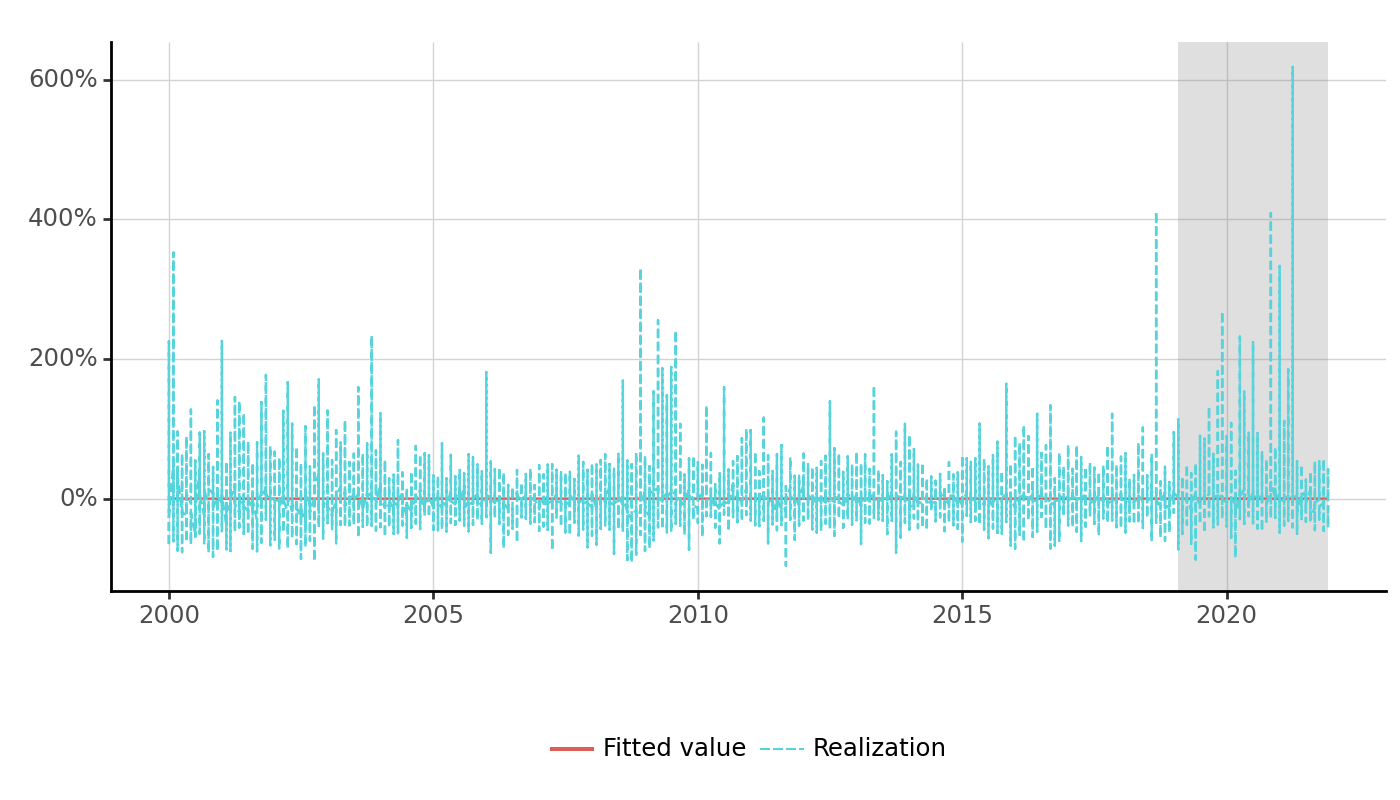

In [19]:
# Set up Elastic Net Model
lm_model = ElasticNet(
    alpha=optimal_alpha_panel, # Strength of regularization (lambda penalty)
    l1_ratio=0.5, # Weight on Lasso vs Ridge (l1_ratio = 1, means 100 pct. Lasso)
    max_iter=5000, # Maximum number of iteration for optimization
    fit_intercept=False 
)  
    
lm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", lm_model)
])
print(pl.prediction_plot_panel(data, lm_pipeline))

### Selected Factors

In [51]:
def extract_selected_features(lm_pipeline, finder, data):
    # Fit the pipeline to the data
    lm_pipeline.fit(data.drop(columns=["ret_excess"]), data["ret_excess"])

    # Extract selected features based on the type of regression
    if 'lasso' in lm_pipeline.named_steps['regressor'].__class__.__name__.lower() or 'elasticnet' in lm_pipeline.named_steps['regressor'].__class__.__name__.lower():
        selected_features = pd.DataFrame(
            finder.best_estimator_.named_steps.regressor.coef_ != 0,
            index=lm_pipeline[:-1].named_steps.preprocessor.get_feature_names_out(),
            columns=["selected"]
        )
    elif 'ridge' in lm_pipeline.named_steps['regressor'].__class__.__name__.lower():
        selected_features = pd.DataFrame(
            np.abs(finder.best_estimator_.named_steps.regressor.coef_) > 0.05, # Absolute value 
            index=lm_pipeline[:-1].named_steps.preprocessor.get_feature_names_out(),
            columns=["selected"]
        )
    else:
        raise ValueError("Unsupported regression type. Supported types: Lasso, Elastic Net, Ridge")
    
    # Remove prefixes from variable names if necessary
    selected_features.index = selected_features.index.str.replace("factor_|ff_|q_|macro_", "")

    return selected_features.astype(bool)

factors_Lasso = extract_selected_features(lm_pipeline_Lasso, finder_Lasso, data)
factors_Ridge = extract_selected_features(lm_pipeline_Ridge, finder_Ridge, data)
factors_EN = extract_selected_features(lm_pipeline_EN, finder_EN, data)
selected_factors = pd.concat([factors_Lasso,factors_Ridge,factors_EN], axis = 1)
selected_factors.reset_index(inplace=True)
selected_factors.columns = ['Factor', 'Lasso','Ridge','Elastic Net'] 
melted_factors = pd.melt(selected_factors, id_vars='Factor', var_name='Estimator', value_name='Selected')
melted_factors = melted_factors[melted_factors['Selected']]

NameError: name 'lm_pipeline_Lasso' is not defined

In [ ]:
plot_selection = (ggplot(melted_factors,
        aes(x='Estimator', y='Factor', fill='Estimator')) +
 geom_tile() +
 labs(x="", y="", title="") +
 scale_x_discrete(limits=reversed) + 
 scale_fill_manual(values=["deepskyblue", "red", "violet"], guide = False) +
 theme(axis_text_x=element_text(rotation=70, hjust=1, size = 8), axis_text_y = element_text(size=6),
       figure_size=(6, 7)))
plot_selection.save(filename='plots/selected_factors.png', format='png', verbose=False)

plot_selection